In [1]:
import os
import time
import h5py
import glob
import time
import numpy as np
import xarray as xr

import pandas as pd
import geopandas as gpd

from datetime import datetime

from shapely.geometry import Point

import scipy.stats as stats
from scipy.stats import linregress
from scipy.stats import weibull_min
from scipy.interpolate import RegularGridInterpolator
from scipy.optimize import curve_fit, minimize, fsolve
from scipy.optimize import differential_evolution

import cartopy
import cartopy.feature as cf
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib import patches
import matplotlib.patches as mpatches
import matplotlib.gridspec as gridspec

from pathos.multiprocessing import ProcessingPool as Pool

from playsound import playsound

import sys
sys.path.insert(0, os.path.abspath("../function"))
from ART_downscale import wei_fit_update, fit_yearly_weibull_update, compute_beta, str_exp_fun, epl_fun, myfun_sse, down_wei
from ART_preprocessing import haversine, create_box, space_time_scales_agregations, wet_matrix_extrapolation, autocorrelation_neighborhood, area_lat_lon, spatial_correlation
from ART_plot import plot_neighborhood, plot_scales_aggregation, plot_wet_fraction_matrix, plot_autocorrelation, plot_scatter

import warnings
warnings.filterwarnings('ignore')

playsound is relying on another python subprocess. Please use `pip install pygobject` if you want playsound to run more efficiently.


## Downscaling to Veneto region

In [2]:
yy_s, yy_e = 2001, 2017

In [3]:
CONDITION = 'OVERLEAP'; fig_val = 'OVERLAP'

In [4]:
veneto_dir = os.path.join('/','media','arturo','Arturo','Data','shapes','Europa','Italy','Veneto.geojson')

if os.path.exists(veneto_dir):
    Veneto = gpd.read_file(veneto_dir)
else:
    raise SystemExit(f"File not found: {veneto_dir}")

In [5]:
OBS_dir = os.path.join('/','media','arturo','Arturo','Data','Italy','Weibull','VENETO_WEIBULL_OBS_IMERG_1981_2023.nc')
OBS = xr.open_dataset(OBS_dir)
POS = np.argwhere(~np.isnan(np.nanmean(OBS['Wetdays'].values,axis=0)))

In [ ]:
dir_base = os.path.join('/','media','arturo','Arturo','Data','Italy','Satellite')
data_dir = os.path.join(dir_base,'IMERG','3_hour',f'IMERG_Veneto_3h_2001_01_01_2023_12_31.nc')

if os.path.exists(data_dir):
    DATA = xr.open_dataset(data_dir)
    # DATA = DATA.sel(time=DATA.time.dt.year.isin([np.arange(yy_s,yy_e+1)]))
else:
    raise SystemExit(f"File not found: {data_dir}")

lats = DATA['lat'].data
lons = DATA['lon'].data

lon2d, lat2d = np.meshgrid(lons, lats)

nlon_ref = np.size(lons)
nlat_ref = np.size(lats)

dx = np.abs(lons[1] - lons[0])
dy = np.abs(lats[1] - lats[0])

year_vector = np.unique(pd.to_datetime(DATA['time']).year)

DATES = DATA['time'][:]

DATA

<xarray.Dataset> Size: 646MB
Dimensions:  (time: 67200, lat: 30, lon: 40)
Coordinates:
  * time     (time) datetime64[ns] 538kB 2001-01-01 ... 2023-12-31T21:00:00
  * lat      (lat) float32 120B 44.05 44.15 44.25 44.35 ... 46.75 46.85 46.95
  * lon      (lon) float32 160B 10.05 10.15 10.25 10.35 ... 13.75 13.85 13.95
Data variables:
    PRE      (time, lat, lon) float64 645MB ...
Attributes:
    description:  IMERG 3 hour data for Veneto region

In [ ]:
def ART_downscalling(DATA_in, lat_c, lon_c, PARAM):
    PRE_daily = DATA_in.resample(time ='D').sum(dim='time', skipna=False)

    DATES_daily = PRE_daily['time']

    i_ = np.where(lats==lat_c)[0][0]
    j_ = np.where(lons==lon_c)[0][0]

    IMERG_pixel_1dy = PRE_daily['PRE'][:,i_,j_].data

    IMERG_pixel_1dy_xr = xr.DataArray(
                IMERG_pixel_1dy, 
                coords={'time':PRE_daily['time'].values}, 
                dims=('time'))

    IMERG_WEIBULL_YEAR = fit_yearly_weibull_update(
                IMERG_pixel_1dy_xr, 
                thresh=PARAM['thresh'], 
                maxmiss=PARAM['maxmiss'])

    box_3h, _ = create_box(DATA, lat_c, lon_c, PARAM['npix'], reso=PARAM['resolution'])

    smax = box_3h.shape[0] # max spatial scale
    tscales = np.array([1, 2, 3, 4, 5, 6, 8, 10, 12, 16, 20, 24, 36, 48, 96])*PARAM['dt']
    tscales = tscales[tscales < PARAM['tmax'] + 0.001]
    xscales = np.arange(1, smax+1)
    xscales_km = xscales*PARAM['L1']
    ntscales = np.size(tscales)
    nsscales = np.size(xscales)

    WET_MATRIX = space_time_scales_agregations(
                box_3h, 
                PARAM['L1'], 
                PARAM['condition'], 
                tscales, 
                xscales, 
                PARAM['npix'], 
                PARAM['thresh'])

    xscales_km_2d, tscales_2d = np.meshgrid(xscales_km, tscales)
    ntscales = np.size(tscales)
    nxscales = np.size(xscales)

    tscales_INTER = np.linspace(np.min(tscales), np.max(tscales), PARAM['ninterp'])
    WET_MATRIX_INTER = np.zeros((PARAM['ninterp'], nxscales))
    
    for col in range(nxscales):
        WET_MATRIX_INTER[:, col] = np.interp(tscales_INTER, tscales, WET_MATRIX[:, col])

    WET_MATRIX_EXTRA, new_spatial_scale = wet_matrix_extrapolation(
                WET_MATRIX_INTER, 
                xscales_km, 
                tscales_INTER, 
                PARAM['L1'], 
                PARAM['npix'])

    origin_ref = [PARAM['origin_x'], PARAM['origin_t']]
    target_ref = [PARAM['target_x'], PARAM['target_t']]

    beta = compute_beta(WET_MATRIX_EXTRA, origin_ref, target_ref, new_spatial_scale, tscales_INTER)

    vdist, vcorr, distance_vector = autocorrelation_neighborhood(
                box_3h, 
                t_target = PARAM['target_t'], 
                thresh = PARAM['thresh'], 
                cor_method = PARAM['corr_method'])

    # FIT, _ = curve_fit(str_exp_fun, vdist, vcorr)
    # FIT_d0, FIT_mu0 = FIT
    # FIT, _ = curve_fit(epl_fun, vdist, vcorr)
    # FIT_eps, FIT_alp = FIT

    vdist_sorted = np.sort(vdist) # order distance
    vcorr_sorted = vcorr[np.argsort(vdist)] # order correlation in relation to distance
    toll_cluster = 0.5

    cluster = np.zeros(len(vdist_sorted))
    count = 0
    for i in range(1, len(vdist_sorted)):
        if np.abs(vdist_sorted[i]-vdist_sorted[i-1]) < toll_cluster:
            cluster[i] = count
        else:
            count = count + 1
            cluster[i] = count

    clust = set(cluster) # Extract only the uniques values
    nclust = len(clust) # Numero de grupos

    vdist_ave = np.zeros(nclust)
    vcorr_ave = np.zeros(nclust)
    for ei, elem in enumerate(clust):
        di = vdist_sorted[cluster==elem] # Distance
        ci = vcorr_sorted[cluster==elem] # Correlation
        vdist_ave[ei] = np.mean(di) # Mean Distance
        vcorr_ave[ei] = np.mean(ci) # Mean Correlation

    # FIT, _ = curve_fit(epl_fun, vdist_ave, vcorr_ave)
    # FIT_ave_eps, FIT_ave_alp = FIT

    # bounds = [(0.0, 200),(0, 1)] # ORIGINAL LIMITS BY ZORZETO
    bounds = [(0.0, 25.0),(0, 0.3)] # NEW LIMITS USING ALL CORRELATIONS FUNCTION IN VENETO
    
    def myfun(pardown):
        return myfun_sse(vdist_ave, vcorr_ave, pardown, PARAM['L1'], acf=PARAM['acf'])

    with Pool(nodes=PARAM['cores']) as pool:
        resmin = differential_evolution(
            myfun,
            bounds,
            disp=True,
            tol=0.05,
            atol=0.05,
            workers=pool.map
        )

    param1 = resmin.x[0]
    param2 = resmin.x[1]

    NYd, CYd, WYd, gamYd, _ = down_wei(
                        IMERG_WEIBULL_YEAR[:,0], 
                        IMERG_WEIBULL_YEAR[:,1], 
                        IMERG_WEIBULL_YEAR[:,2], 
                        PARAM['L1'], 
                        PARAM['L0'], 
                        beta, 
                        (param1, param2), 
                        acf=PARAM['acf'])

    DOWN_WEIBULL_YY = np.zeros([len(NYd), 3])
    DOWN_WEIBULL_YY[:,0] = NYd
    DOWN_WEIBULL_YY[:,1] = CYd
    DOWN_WEIBULL_YY[:,2] = WYd

    dict_out = dict({'beta':beta, 'gamma':gamYd, 'param1':param1, 'param2':param2})

    return IMERG_WEIBULL_YEAR, DOWN_WEIBULL_YY, dict_out

In [ ]:
parameters = dict({
    'L1':10,
    'origin_x': 10,
    'radio':0.1,
    'npix':5,
    'thresh': 2,

    'maxmiss':40,
    'condition': 'OVERLEAP',

    'L0':0,
    'tmax': 48,
    'dt': 3,

    'origin_t': 24,
    'target_x': 0,
    'target_t': 24,

    'ninterp':2000,

    'acf': 'mar',
    'corr_method':'pearson',
    'cores': 12,
})

In [ ]:
IMERG_WD = np.zeros([len(year_vector),len(lats),len(lons)])*np.nan
IMERG_SC = np.zeros([len(year_vector),len(lats),len(lons)])*np.nan
IMERG_SH = np.zeros([len(year_vector),len(lats),len(lons)])*np.nan

DOWN_WD = np.zeros([len(year_vector),len(lats),len(lons)])*np.nan
DOWN_SC = np.zeros([len(year_vector),len(lats),len(lons)])*np.nan
DOWN_SH = np.zeros([len(year_vector),len(lats),len(lons)])*np.nan

M_beta = np.zeros([len(lats),len(lons)])*np.nan
M_gamma = np.zeros([len(lats),len(lons)])*np.nan

In [ ]:
# 547 min para 170 puntos, 3.2 min por punto

start_time = time.time()

step = 1
for la, lo in POS[164:]:
    print(f'PROCESING STEP {step} of {len(POS)}')
    IMERG_WEIBULL_YY, DOWN_WEIBULL_YY, dict_out, = ART_downscalling(DATA, lats[la], lons[lo], parameters)
    IMERG_WD[:,la,lo] = IMERG_WEIBULL_YY[:,0]
    IMERG_SC[:,la,lo] = IMERG_WEIBULL_YY[:,1]
    IMERG_SH[:,la,lo] = IMERG_WEIBULL_YY[:,2]

    DOWN_WD[:,la,lo] = DOWN_WEIBULL_YY[:,0]
    DOWN_SC[:,la,lo] = DOWN_WEIBULL_YY[:,1]
    DOWN_SH[:,la,lo] = DOWN_WEIBULL_YY[:,2]

    M_beta[la,lo] = dict_out['beta']
    M_gamma[la,lo] = dict_out['gamma']
    
    step += 1
    print()

end_time = time.time()
elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time:.2f} seconds")

Step: 1
differential_evolution step 1: f(x)= 0.02238641977156742
differential_evolution step 2: f(x)= 0.019300923943824735
differential_evolution step 3: f(x)= 0.018881689035524656
Polishing solution with 'L-BFGS-B'
Gamma value: 0.9456656478662147

Step: 1
differential_evolution step 1: f(x)= 0.016173267543942323
differential_evolution step 2: f(x)= 0.016065538361122282
Polishing solution with 'L-BFGS-B'
Gamma value: 0.9535361218093913

Step: 1
differential_evolution step 1: f(x)= 0.013481972915981976
differential_evolution step 2: f(x)= 0.012983317480215084
differential_evolution step 3: f(x)= 0.012983317480215084
Polishing solution with 'L-BFGS-B'
Gamma value: 0.9547572370354341

Step: 1
differential_evolution step 1: f(x)= 0.01520944449216865
differential_evolution step 2: f(x)= 0.01520944449216865
Polishing solution with 'L-BFGS-B'
Gamma value: 0.9471463956103835

Step: 1
differential_evolution step 1: f(x)= 0.01509653014743489
differential_evolution step 2: f(x)= 0.014512635833227

In [ ]:
# Search a specific lat and lon in POS array for verify in IMERG_veneto_8_pixel_check.ipynb
target = [la, lo]
indices = np.where((POS == target).all(axis=1))[0]
print(lats[la], lons[lo])
print(indices)

In [ ]:
WEIBULL_xr = xr.Dataset(data_vars={
                "IMERG_WD": (("time","lat","lon"), IMERG_WD),
                "IMERG_SC": (("time","lat","lon"), IMERG_SC),
                "IMERG_SH": (("time","lat","lon"), IMERG_SH),
                "DOWN_WD": (("time","lat","lon"), DOWN_WD),
                "DOWN_SC": (("time","lat","lon"), DOWN_SC),
                "DOWN_SH": (("time","lat","lon"), DOWN_SH),
                "BETA":(("lat","lon"), M_beta),
                "GAMMA":(("lat","lon"), M_gamma)},
                    coords={'time': pd.to_datetime(year_vector, format='%Y'), 'lat': lats, 'lon': lons},
                    attrs=dict(description=f"Weibull parameters for Veneto using IMERG data"))

WEIBULL_xr.IMERG_WD.attrs["units"] = "Number of days"
WEIBULL_xr.IMERG_WD.attrs["long_name"] = "IMERG wet days"

WEIBULL_xr.IMERG_SC.attrs["units"] = "dimensionless"
WEIBULL_xr.IMERG_SC.attrs["long_name"] = "IMERG Scale"

WEIBULL_xr.IMERG_SH.attrs["units"] = "dimensionless"
WEIBULL_xr.IMERG_SH.attrs["long_name"] = "IMERG Shape"

WEIBULL_xr.DOWN_WD.attrs["units"] = "Number of days"
WEIBULL_xr.DOWN_WD.attrs["long_name"] = "DOWN wet days"

WEIBULL_xr.DOWN_SC.attrs["units"] = "dimensionless"
WEIBULL_xr.DOWN_SC.attrs["long_name"] = "DOWN Scale"

WEIBULL_xr.DOWN_SH.attrs["units"] = "dimensionless"
WEIBULL_xr.DOWN_SH.attrs["long_name"] = "DOWN Shape"

WEIBULL_xr.BETA.attrs["units"] = "dimensionless"
WEIBULL_xr.BETA.attrs["long_name"] = "Beta parameter"

WEIBULL_xr.GAMMA.attrs["units"] = "dimensionless"
WEIBULL_xr.GAMMA.attrs["long_name"] = "Gamma parameter"

WEIBULL_xr.lat.attrs["units"] = "degrees_north"
WEIBULL_xr.lat.attrs["long_name"] = "Latitude"

WEIBULL_xr.lon.attrs["units"] = "degrees_east"
WEIBULL_xr.lon.attrs["long_name"] = "Longitude"

Export PRE data to /media/arturo/Arturo/Data/Italy/Weibull/VENETO_WEIBULL_IMERG_2001_2023.nc


In [ ]:
WEIBULL_xr

In [ ]:
WEIBULL_out = os.path.join('/','media','arturo','Arturo','Data','Italy','Weibull',f'VENETO_WEIBULL_IMERG_{year_vector[0]}_{year_vector[-1]}.nc')
print(f'Export PRE data to {WEIBULL_out}')
# WEIBULL_xr.to_netcdf(WEIBULL_out)

Text(0.0, 1.0, '(e) Gamma')

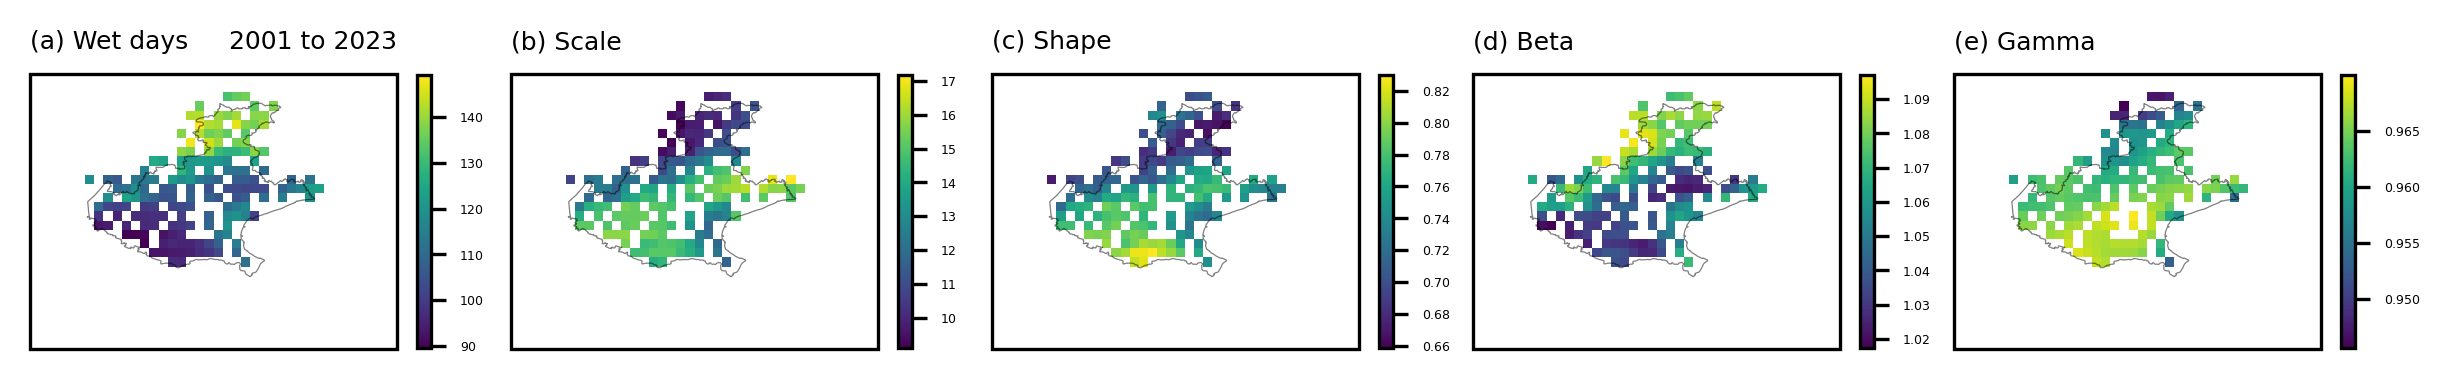

In [ ]:
cmap = plt.cm.Spectral_r
proj = ccrs.PlateCarree()

fig = plt.figure(figsize=(10,2),dpi=300)
gs = gridspec.GridSpec(1,5)

# ================================================================
ax1 = plt.subplot(gs[0, 0], projection = proj)
ax1.set_extent([10.5, 13.2, 44.7, 46.9], crs=proj)
ax1.add_geometries(Veneto.geometry, ccrs.PlateCarree(), edgecolor='k', facecolor='None', linewidth=0.3, alpha=0.5)
a1 = ax1.pcolormesh(lon2d, lat2d, np.mean(WEIBULL_xr['DOWN_WD'],axis=0))
cbar = plt.colorbar(a1, fraction=0.034)
cbar.ax.tick_params(labelsize=3)
ax1.set_title('(a) Wet days', loc='left', fontsize=6)
ax1.set_title(f'{year_vector[0]} to {year_vector[-1]}', loc='right', fontsize=6)

# ================================================================
ax1 = plt.subplot(gs[0, 1], projection = proj)
ax1.set_extent([10.5, 13.2, 44.7, 46.9], crs=proj)
ax1.add_geometries(Veneto.geometry, ccrs.PlateCarree(), edgecolor='k', facecolor='None', linewidth=0.3, alpha=0.5)
a1 = ax1.pcolormesh(lon2d, lat2d, np.mean(WEIBULL_xr['DOWN_SC'],axis=0))
cbar = plt.colorbar(a1, fraction=0.034)
cbar.ax.tick_params(labelsize=3)
ax1.set_title('(b) Scale', loc='left', fontsize=6)

# ================================================================
ax1 = plt.subplot(gs[0, 2], projection = proj)
ax1.set_extent([10.5, 13.2, 44.7, 46.9], crs=proj)
ax1.add_geometries(Veneto.geometry, ccrs.PlateCarree(), edgecolor='k', facecolor='None', linewidth=0.3, alpha=0.5)
a1 = ax1.pcolormesh(lon2d, lat2d, np.mean(WEIBULL_xr['DOWN_SH'],axis=0))
cbar = plt.colorbar(a1, fraction=0.034)
cbar.ax.tick_params(labelsize=3)
ax1.set_title('(c) Shape', loc='left', fontsize=6)

# ================================================================
ax1 = plt.subplot(gs[0, 3], projection = proj)
ax1.set_extent([10.5, 13.2, 44.7, 46.9], crs=proj)
ax1.add_geometries(Veneto.geometry, ccrs.PlateCarree(), edgecolor='k', facecolor='None', linewidth=0.3, alpha=0.5)
a1 = ax1.pcolormesh(lon2d, lat2d, WEIBULL_xr['BETA'])
cbar = plt.colorbar(a1, fraction=0.034)
cbar.ax.tick_params(labelsize=3)
ax1.set_title('(d) Beta', loc='left', fontsize=6)

# ================================================================
ax1 = plt.subplot(gs[0, 4], projection = proj)
ax1.set_extent([10.5, 13.2, 44.7, 46.9], crs=proj)
ax1.add_geometries(Veneto.geometry, ccrs.PlateCarree(), edgecolor='k', facecolor='None', linewidth=0.3, alpha=0.5)
a1 = ax1.pcolormesh(lon2d, lat2d, WEIBULL_xr['GAMMA'])
cbar = plt.colorbar(a1, fraction=0.034)
cbar.ax.tick_params(labelsize=3)
ax1.set_title('(e) Gamma', loc='left', fontsize=6)